In [47]:
path = "Results/masked_result_two_head_attention_same/electricity/"
# path = "aaai_Outputs_electricity_e336_d168_testprune_2_rp/electricity/"
# path = "Outputs_electricity_e336_d168_original_huber/electricity/"
#path = "Outputs_synthetic/foodinflation/"

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
preds = np.load(path+'trans-nll-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
#preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
#trues = trues.reshape(-1, preds.shape[-2], preds.shape[-1])
# [samples, pred_len, dimensions]
print(preds.shape, trues.shape, inputs.shape)

print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

(54, 168, 1) (54, 168, 1) (54, 336, 1)
mse :  6637.372 mae:  58.48813


/mnt/cat/data/sandy/anaconda3/envs/telemanom/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


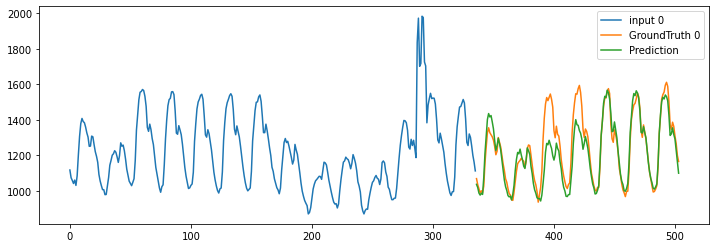

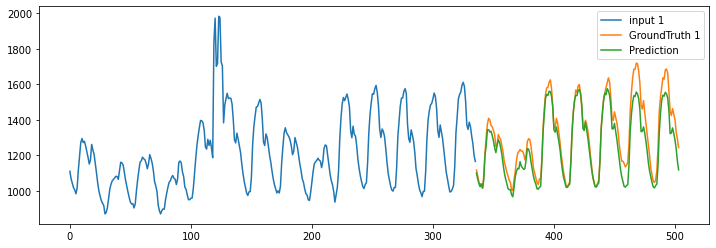

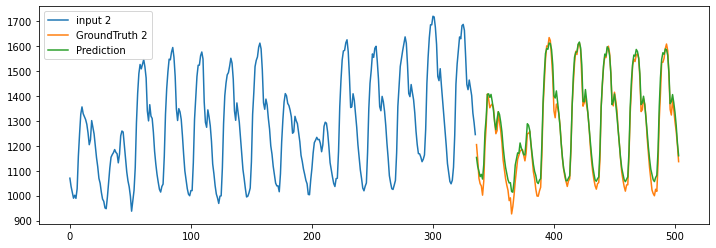

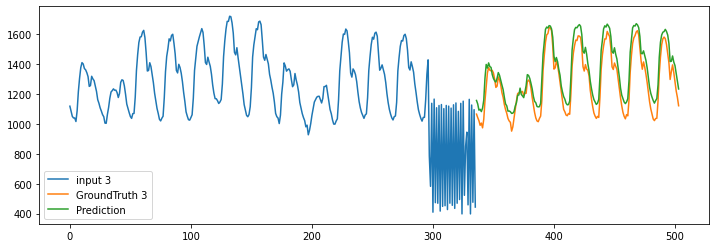

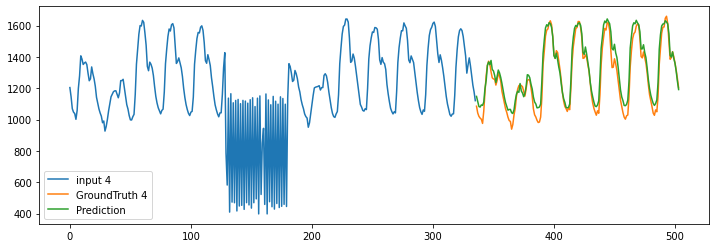

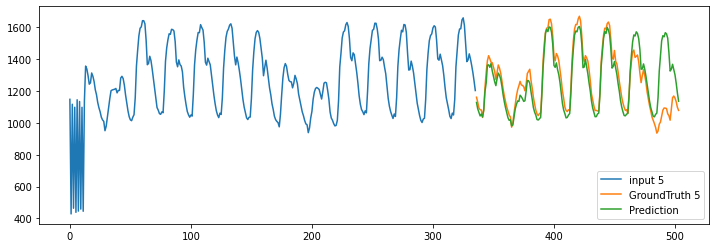

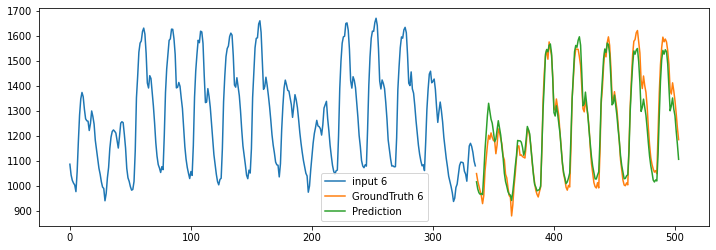

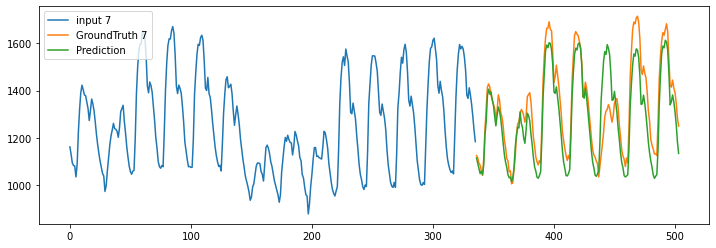

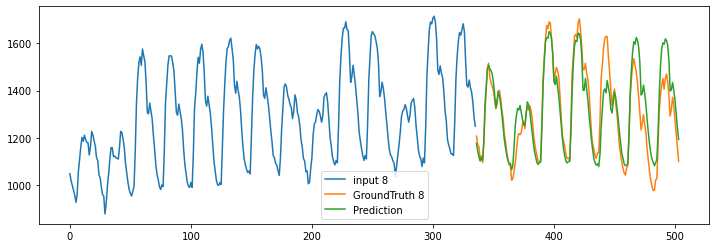

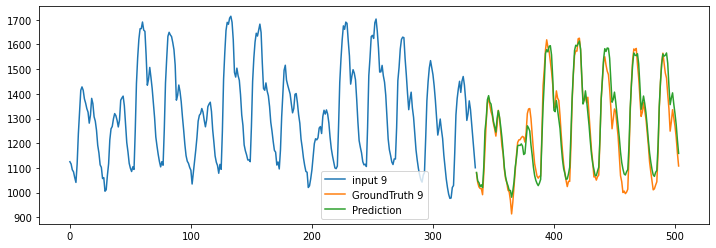

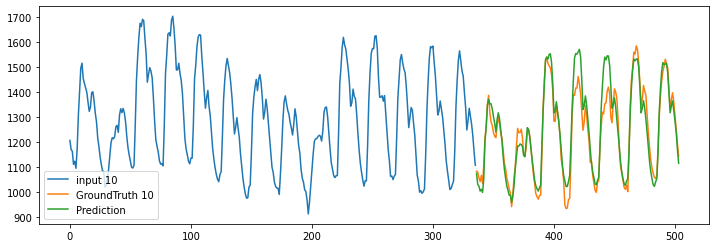

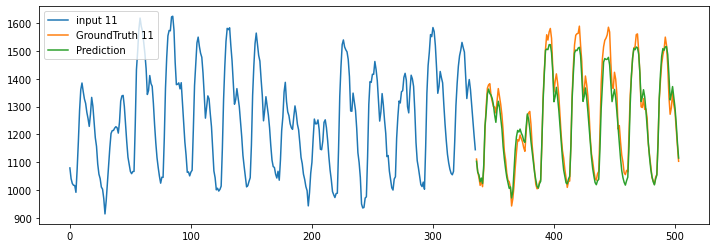

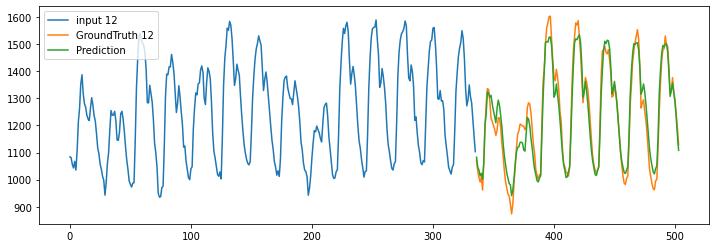

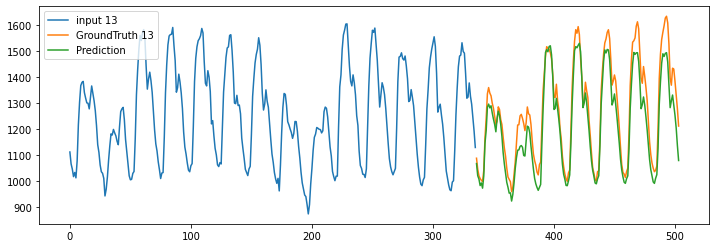

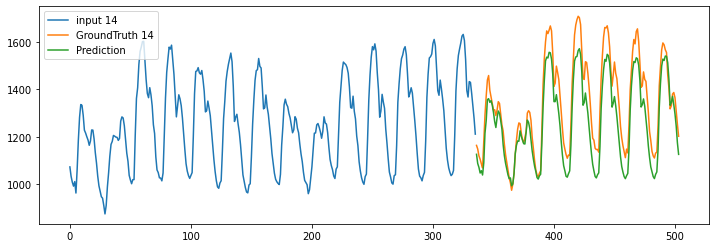

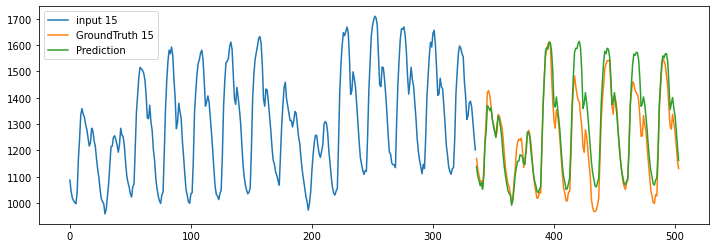

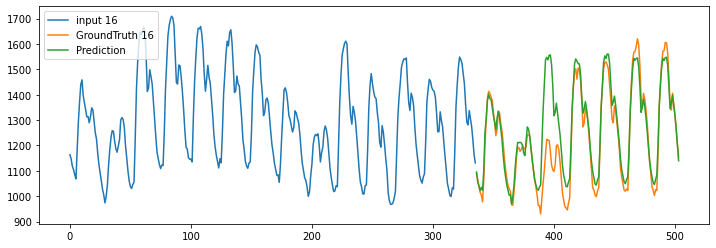

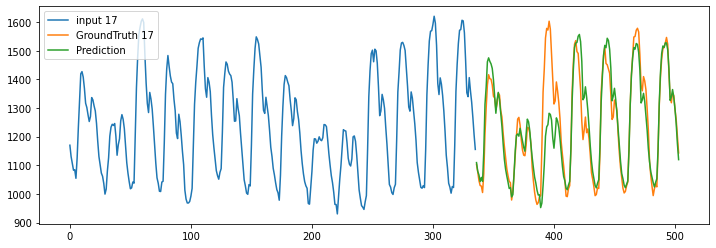

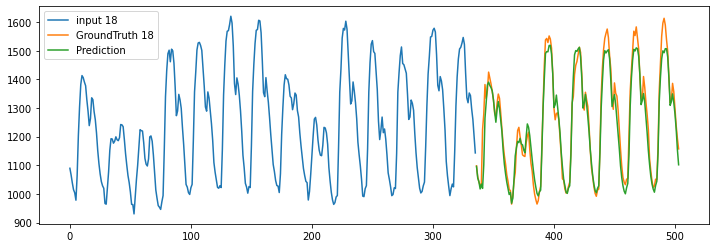

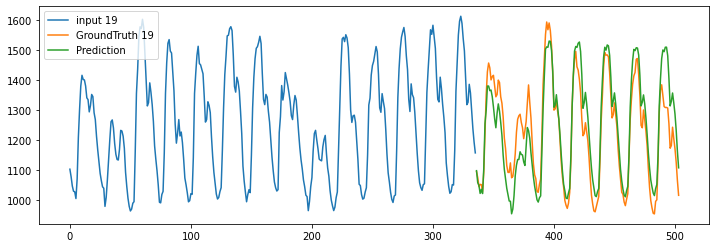

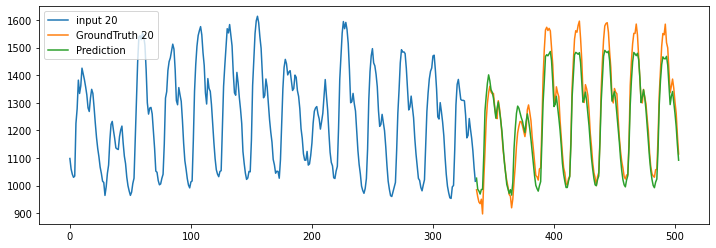

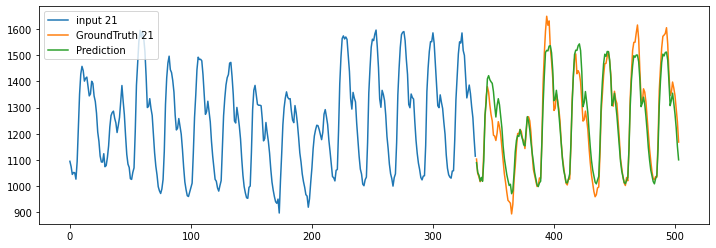

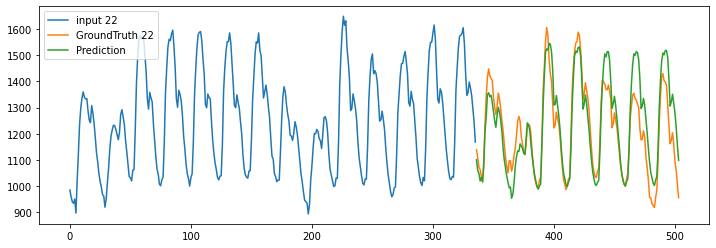

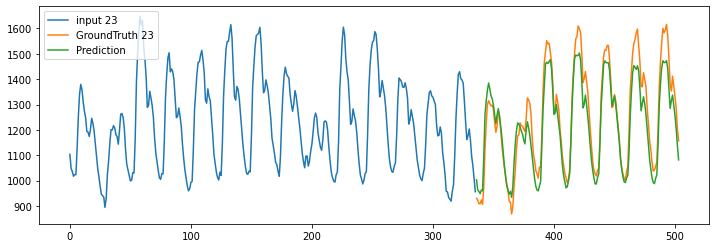

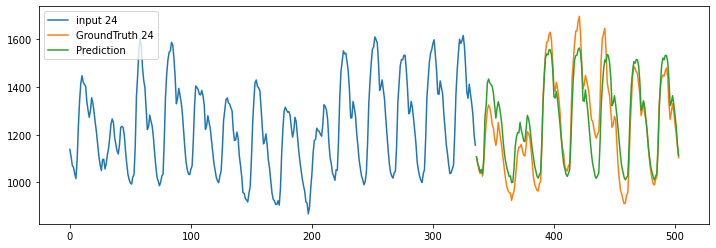

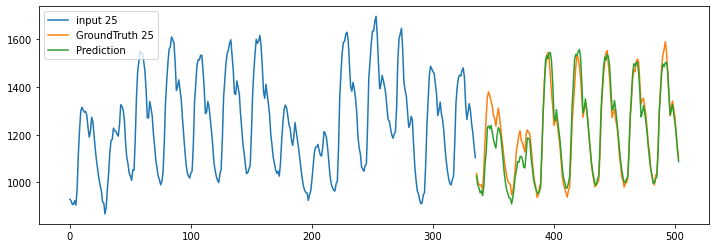

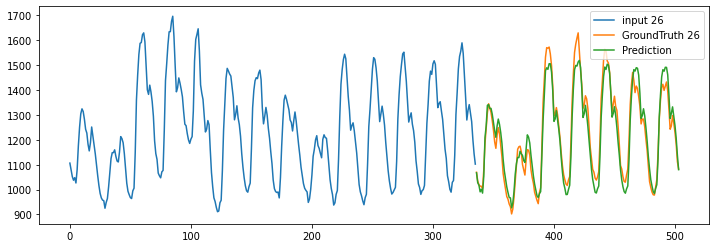

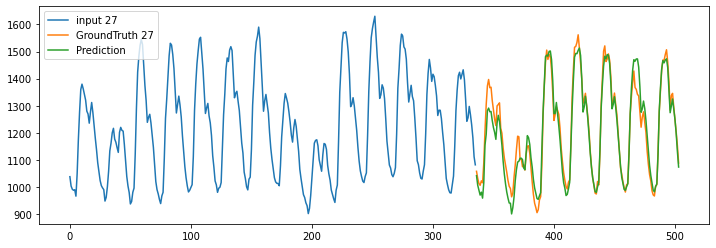

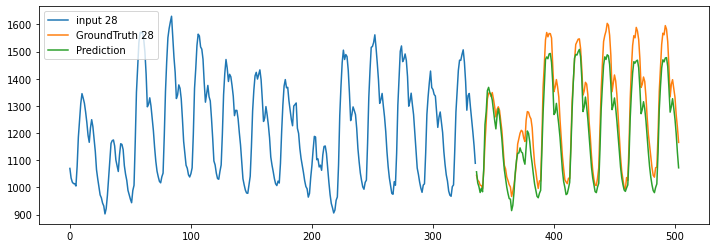

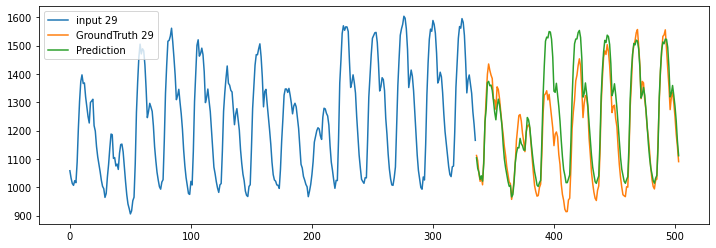

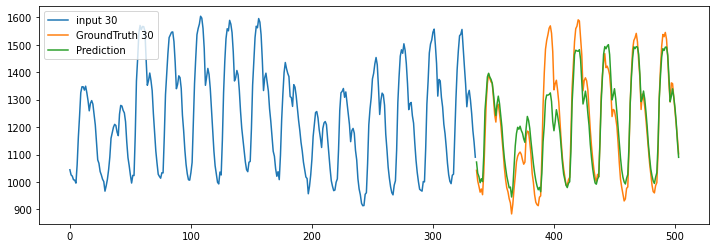

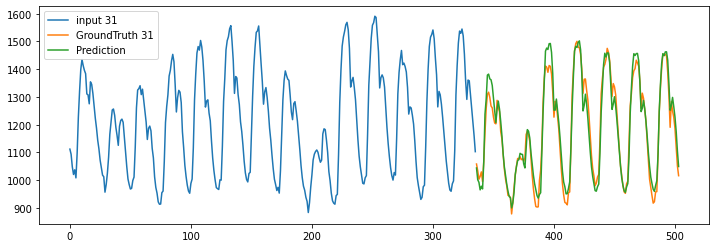

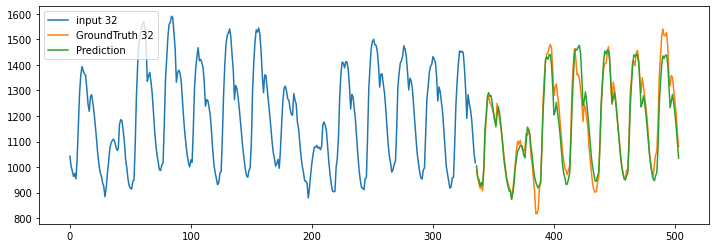

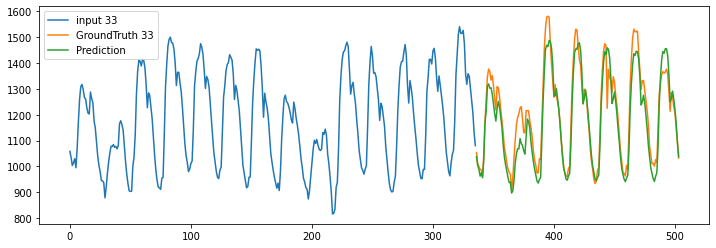

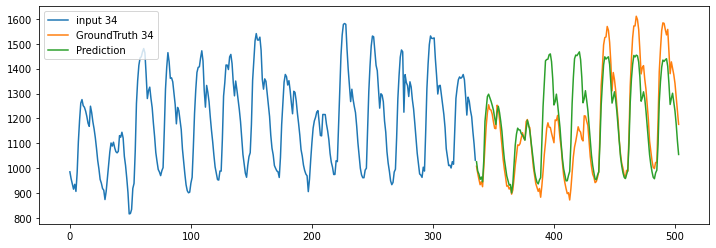

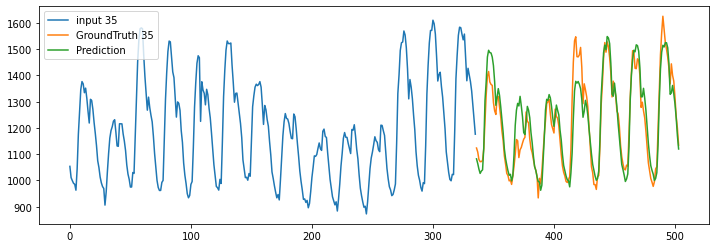

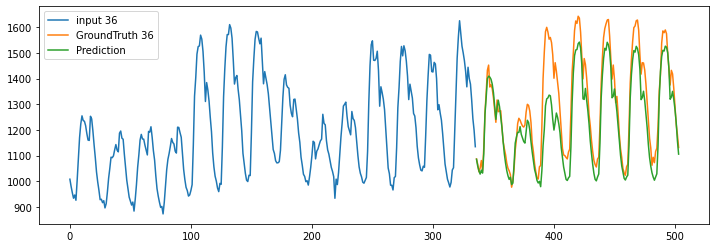

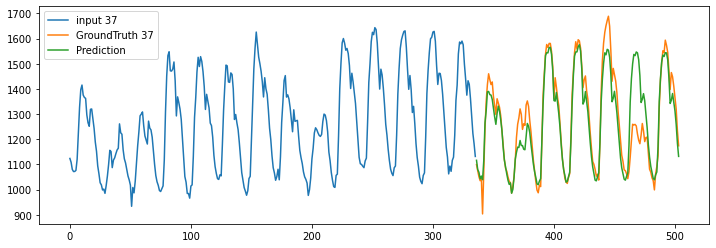

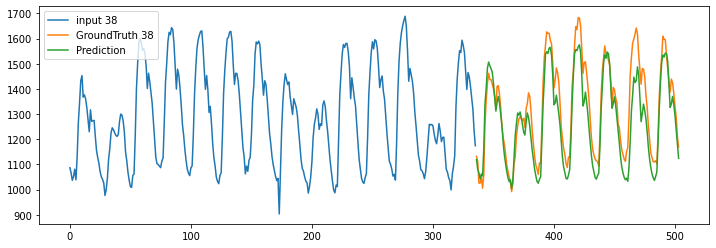

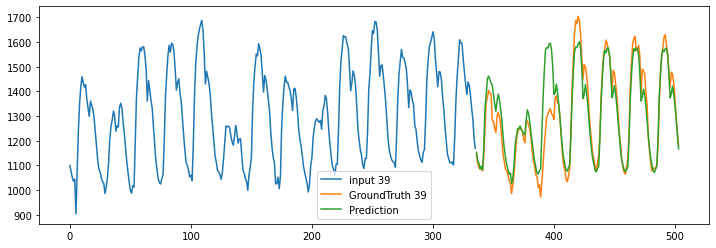

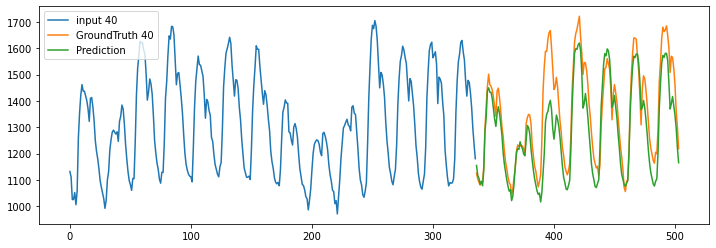

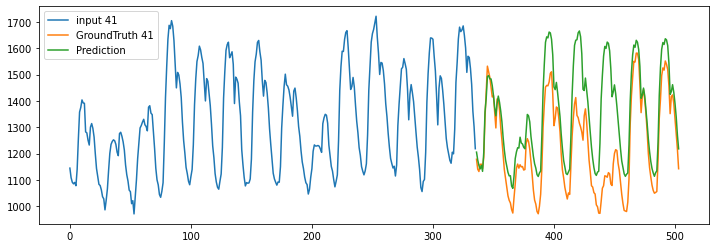

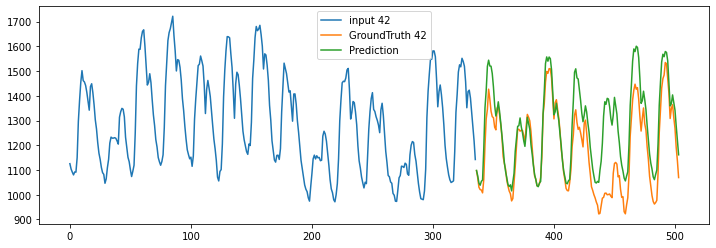

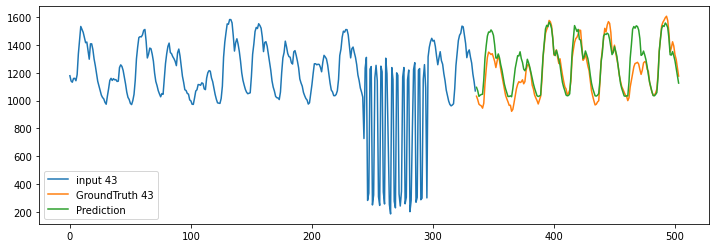

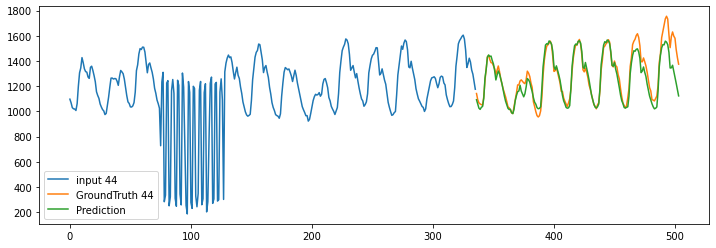

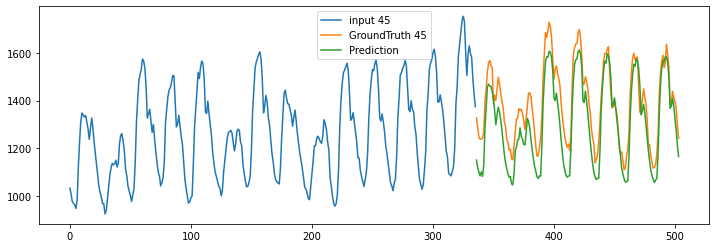

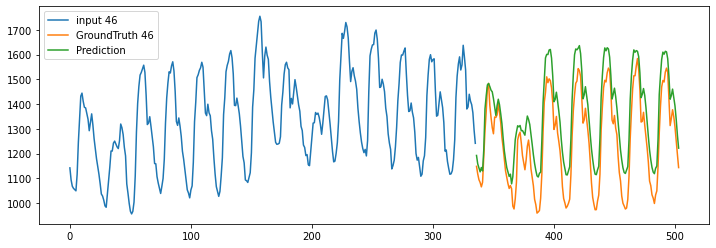

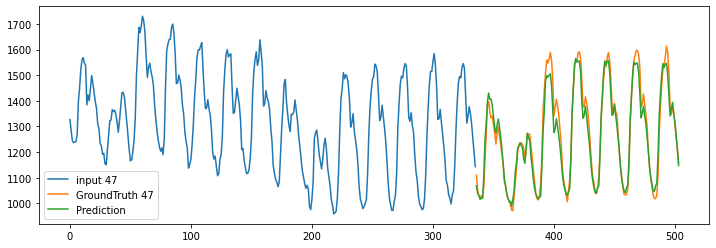

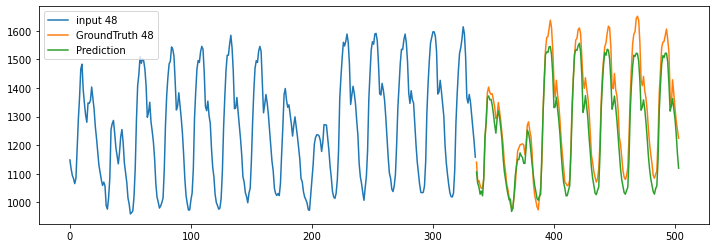

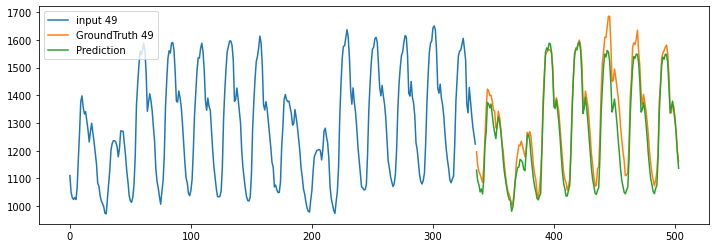

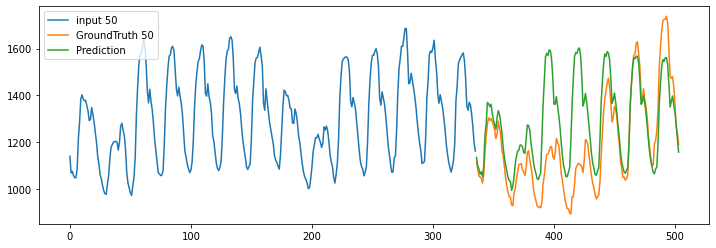

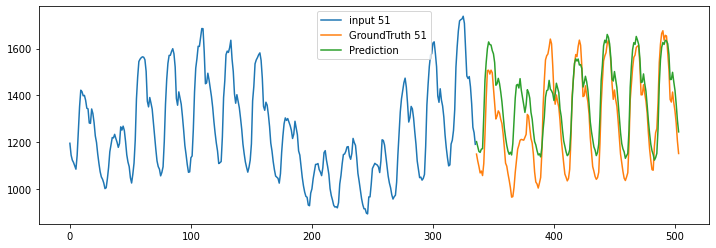

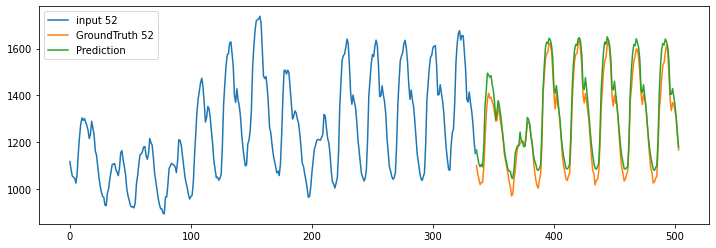

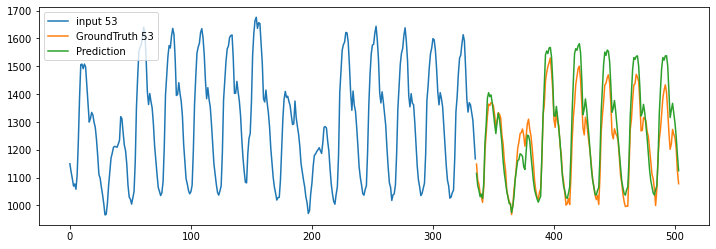

In [49]:
plt.rcParams['figure.figsize'] = (12,4)
for i in range(54):
    plt.figure()
    c =i 
    x = np.arange(504)
    a = 336
    plt.plot(x[:a],inputs[c],label='input '+str(c))
    plt.plot(x[a:],trues[c,:,0], label='GroundTruth '+str(c))
    #for i in range(1):

    plt.plot(x[a:],preds[c,:,0], label='Prediction ')
    
    plt.legend()
    # fig = plt.figure()
    # plt.savefig("images/trans-mse_test_"+str(i)+".png")
    
    # plt.show()

In [7]:
preds_original = np.load("Results/march/Outputs/Output_original_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_train = np.load("Results/march/Outputs/Output_synthetic_train_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_test = np.load("Results/march/Outputs/Output_synthetic_test_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_both = np.load("Results/march/Outputs/Output_synthetic_both_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
trues = np.load("Results/march/Outputs/Output_original_point_0.2_per/electricity/"+'targets.npy')


In [8]:
print("original\t\ttrain\t\ttest\t\tboth")
for i in range(len(trues)):
    print(f"{mean_squared_error(trues.squeeze()[i,:],preds_original.squeeze())[i,:]:0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_train.squeeze()[i,:]):0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_test.squeeze()[i,:]):0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_both.squeeze()[i,:]):0.2f}")

original		train		test		both


ValueError: Found input variables with inconsistent numbers of samples: [168, 54]

In [3]:
import torch
ex_mask = torch.tensor([1,1,0,0,1],dtype=bool)
print(ex_mask)
# ex_mask = attn_mask.masked_fill(ex_mask==True,value=True)
# print(ex_mask)

tensor([ True,  True, False, False,  True])


In [11]:
ex_mask = torch.tensor(ex_mask,dtype=bool)
head1 = ex_mask * ex_mask.unsqueeze(-1)
head2 = torch.zeros_like(head1)==1
ex = torch.stack((head1,head2))
# ex_mask = torch.tensor(ex,dtype=bool)
print(ex)

tensor([[[ True,  True, False, False,  True],
         [ True,  True, False, False,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [ True,  True, False, False,  True]],

        [[False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]]])


/mnt/cat/data/sandy/anaconda3/envs/telemanom/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [27]:
import numpy as np 
x= np.random.randn(3,5,13)
ds = np.array([np.repeat([[1,1,1,1]],5,axis=0),np.repeat([[2,2,2,2]],5,axis=0),np.repeat([[3,3,3,3]],5,axis=0)])

In [37]:
ds = torch.tensor(ds)

In [40]:
ds.transpose(1,0).reshape(-1,4)

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]])

In [35]:
ds.reshape(-1,4)

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3],
       [3, 3, 3, 3]])